## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model

In [ ]:
sns.set(style='white')
plt.style.use('seaborn-white')

### 데이터 로드

In [ ]:
dataset_path = get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

### 데이터 확인

In [ ]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',       # NA는 ? 처리
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [ ]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [ ]:
dataset["Origin"].unique()

array([1, 3, 2])

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
# one-hot 형태로 변경
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0) # 비율 0.8
test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

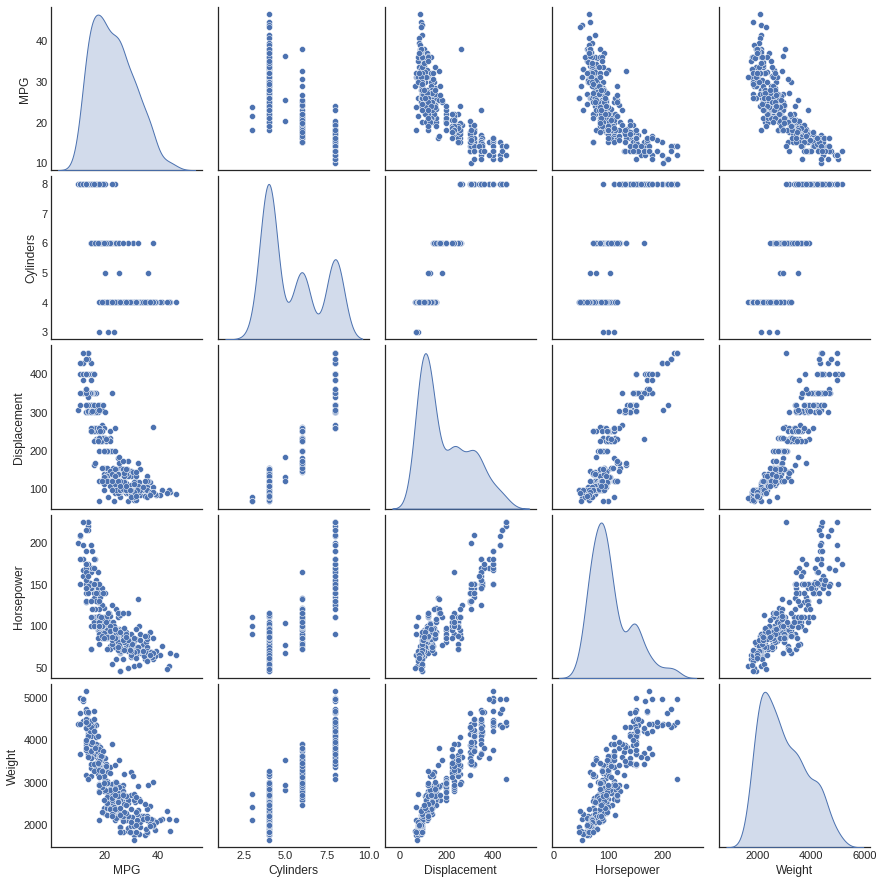

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Horsepower", "Weight"]], diag_kind="kde"); # diag_kind: 겹치는 부분(대각선)

In [ ]:
# MPG 제외한 결과 why? MPG는 정답이기 때문
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화

In [ ]:
def normalization(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

### 모델 구성

In [ ]:
def build_model():
  input = Input(shape=(len(train_dataset.keys())), name='input')
  hidden1 = Dense(64, activation='relu', name='dense1')(input)
  hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
  output = Dense(1, name='output')(hidden2)

  model = Model(inputs=[input], outputs=output)

  model.compile(loss='mse',
                optimizer=RMSprop(0.001),
                metrics=['mae', 'mse'])
  
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


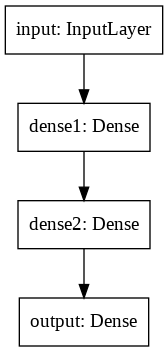

In [ ]:
plot_model(model)

### 샘플 데이터 확인

In [ ]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [ ]:
epochs = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs=epochs, validation_split=0.2)

Epoch 1/1000
8/8 [==============================] - 0s 22ms/step - loss: 567.4576 - mae: 22.5674 - mse: 567.4576 - val_loss: 559.3543 - val_mae: 22.3591 - val_mse: 559.3543
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 517.1339 - mae: 21.4413 - mse: 517.1339 - val_loss: 508.1661 - val_mae: 21.1892 - val_mse: 508.1661
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 466.7931 - mae: 20.2475 - mse: 466.7931 - val_loss: 451.5197 - val_mae: 19.8064 - val_mse: 451.5197
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 411.6043 - mae: 18.8596 - mse: 411.6043 - val_loss: 389.7282 - val_mae: 18.2039 - val_mse: 389.7282
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 353.1606 - mae: 17.2620 - mse: 353.1606 - val_loss: 326.7452 - val_mae: 16.4260 - val_mse: 326.7452
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 293.4069 - mae: 15.5345 - mse: 293.4069 - val_loss: 263.6991 - val_

### 모델 학습 시각화

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,567.457642,22.567411,567.457642,559.354309,22.359119,559.354309,0
1,517.133850,21.441319,517.133850,508.166107,21.189194,508.166107,1
2,466.793091,20.247498,466.793091,451.519653,19.806374,451.519653,2
3,411.604309,18.859602,411.604309,389.728241,18.203903,389.728241,3
4,353.160645,17.261990,353.160645,326.745239,16.426033,326.745239,4
...,...,...,...,...,...,...,...
995,2.482383,1.007815,2.482383,9.849309,2.506826,9.849309,995
996,2.403842,0.998496,2.403842,9.861044,2.463132,9.861044,996
997,2.268706,0.932660,2.268706,9.961937,2.501921,9.961937,997
998,2.341803,1.009784,2.341803,9.757737,2.372029,9.757737,998


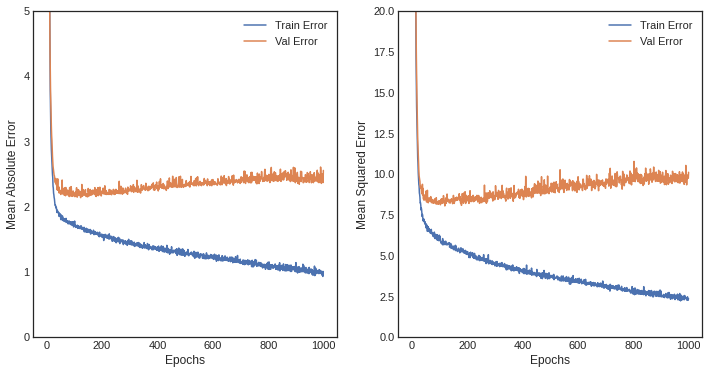

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0, 5])
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0, 20])
  plt.legend()

  plt.show()

plot_history(history)

### EarlyStopping을 이용한 규제화

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = build_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 0s 18ms/step - loss: 551.2116 - mae: 22.1877 - mse: 551.2116 - val_loss: 534.2281 - val_mae: 21.7370 - val_mse: 534.2281
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 491.8141 - mae: 20.7909 - mse: 491.8141 - val_loss: 473.2716 - val_mae: 20.2557 - val_mse: 473.2716
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 434.7311 - mae: 19.3587 - mse: 434.7311 - val_loss: 410.5753 - val_mae: 18.6412 - val_mse: 410.5753
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 373.9463 - mae: 17.7574 - mse: 373.9463 - val_loss: 342.9613 - val_mae: 16.7655 - val_mse: 342.9613
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 310.0888 - mae: 15.9289 - mse: 310.0888 - val_loss: 274.3433 - val_mae: 14.7240 - val_mse: 274.3433
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 245.6359 - mae: 13.9949 - mse: 245.6359 - val_loss: 207.6846 - val_

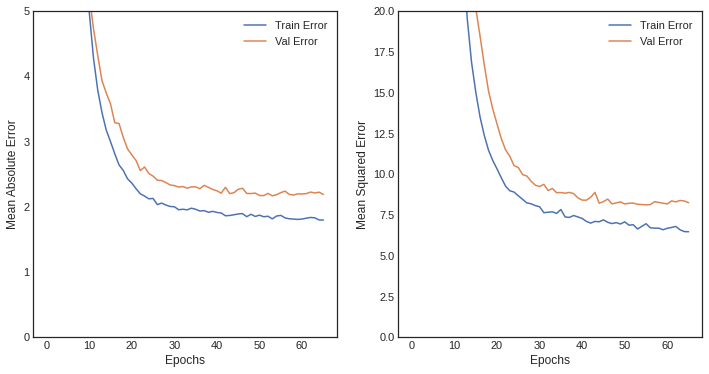

In [ ]:
plot_history(history)

### 모델 평가

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(mae)
# MPG가 약 1.77의 오차 발생

3/3 - 0s - loss: 5.2160 - mae: 1.7753 - mse: 5.2160
1.7753472328186035


### 학습된 모델을 통한 예측

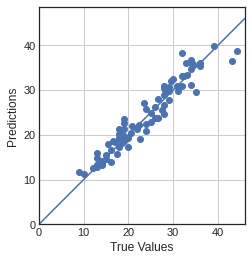

In [ ]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

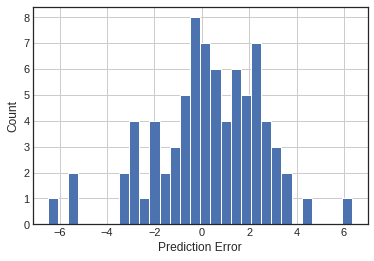

In [ ]:
error = test_pred - test_labels
plt.hist(error, bins=30)
plt.xlabel("Prediction Error")
plt.grid()
plt.ylabel("Count");